<a href="https://colab.research.google.com/github/dzejkopjarosinski/ZespolR/blob/main/MLF_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importy**

In [ ]:
#Biblioteka do Backtestingu nie ma sensu, nie ma ona większego zastosowania przy szacowaniu wartości portfela 

!pip install backtesting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173804 sha256=8385f5d50fc1b29a554546fe978c59aaeafc383231e911f6628fb0227e0852c1
  Stored in directory: /root/.cache/pip/wheels/e2/30/7f/19cbe31987c6ebdb47f1f510343249066711609e3da2d57176
Successfully built backtesting


In [ ]:
#Modelowanie
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from scipy.optimize import minimize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
import yfinance as yf
import datetime

# Dane gtowe

In [179]:
# SP500 data obtained from Github
sp500_index = pd.read_csv('sp500_index.csv')
stock_prices = pd.read_csv('stock_prices.csv')
keystats = pd.read_csv('keystats.csv')
forward_sample = pd.read_csv('forward_sample.csv')

#Dane z Yahoo finance
sp500_all = pd.read_csv("DataFrame_SP500_all.csv")

#Dane z Quandl
#quandl_companies = pd.read_csv("SP500_companies.csv")

In [5]:
print(f'''
SP500_data from Github:

sp500_index min: {sp500_index.Date.min()} max: {sp500_index.Date.max()}
stock_prices: min: {stock_prices.Date.min()} min: {stock_prices.Date.max()}
keystats: min: {keystats.Date.min()} max: {keystats.Date.max()}
forward_sample: min: {forward_sample.Date.min()} max: {forward_sample.Date.max()}

Data from Quandl:
Quandl: min: {quandl_companies.Date.min()} max: {quandl_companies.Date.max()}

Data from yahoo finance:
sp500_all: min: {sp500_all.date.min()} max: {sp500_all.date.max()}
''')

NameError: ignored

In [180]:
sp500_all.head()

,Unnamed: 0,ticker,date,asset_debt_coverage,net_income,return_on_equity,return_on_assets,current_assets,current_liabilities,current_ratio,total_asset,total_liabilities,debt_to_equity_ratio,debt_to_assets_ratio
0,0,MMM,2019-12-31,2.172130,5.027400e+10,4.686976e+09,1.125731,1.127800e+10,9.222000e+09,1.222945,4.465900e+10,3.453300e+10,3.410330,0.773260
1,1,MMM,2020-12-31,2.485119,5.142200e+10,3.754085e+09,1.086136,1.357800e+10,7.948000e+09,1.708354,4.734400e+10,3.441300e+10,2.661279,0.726871
2,2,MMM,2021-12-31,2.670600,5.257100e+10,3.282977e+09,1.116821,1.420900e+10,9.035000e+09,1.572662,4.707200e+10,3.195500e+10,2.113845,0.678854
3,3,MMM,2022-12-31,2.867593,5.462300e+10,3.491261e+09,1.175826,1.355900e+10,9.523000e+09,1.423816,4.645500e+10,3.168500e+10,2.145227,0.682058
4,4,AOS,2022-12-31,9.082311,2.967400e+09,3.235789e+08,0.890496,1.488800e+09,9.342000e+08,1.593663,3.332300e+09,1.584600e+09,0.906677,0.475527


#Model

In [181]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn import tree
import graphviz

In [182]:

training_data = keystats.set_index('Date')
training_data.dropna(axis=0, how='any', inplace=True)
features = training_data.columns[6:]

X_train = training_data[features].values

OUTPERFORMANCE = 10

y_train = [
  1 if stock_p_change - SP500_p_change >= OUTPERFORMANCE else 0
  for stock_p_change, SP500_p_change in zip(
      training_data["stock_p_change"], training_data["SP500_p_change"]
  )]



##Testing Data processing

Sp500 price data 

In [183]:
sp500_price = yf.download('''^GSPC''', start="2014-01-01", end="2014-01-03")
sp500_price = sp500_price.drop(columns = ["Open","High","Low","Close","Volume"])
sp500_price.iloc[0]

[*********************100%***********************]  1 of 1 completed


Adj Close    1831.97998
Name: 2014-01-02 00:00:00, dtype: float64

In [184]:
sp500_prices = yf.download('''^GSPC''', start="2002-01-01", end="2014-01-03")
sp500_prices = sp500_prices.drop(columns = ["Open","High","Low","Close","Volume"])
sp500_prices["date_s"]=sp500_prices.index.strftime("%Y-%m-%d")
sp500_prices

[*********************100%***********************]  1 of 1 completed


,Adj Close,date_s
Date,,
2002-01-02,1154.670044,2002-01-02
2002-01-03,1165.270020,2002-01-03
2002-01-04,1172.510010,2002-01-04
2002-01-07,1164.890015,2002-01-07
2002-01-08,1160.709961,2002-01-08
...,...,...
2013-12-26,1842.020020,2013-12-26
2013-12-27,1841.400024,2013-12-27
2013-12-30,1841.069946,2013-12-30


Getting stock price data for all stocks on 2014-01-02

In [185]:
price_data_for_test = stock_prices[stock_prices["Date"]=='2014-01-02'].T.reset_index().iloc[1:].rename(columns = {"index":"Ticker",2624: "Adj. Close"})
price_data_for_test["Ticker"] = price_data_for_test["Ticker"].apply(str.lower)
price_data_for_test

,Ticker,Adj. Close
1,a,38.633659
2,aa,24.485687
3,aapl,67.984016
4,abbv,44.96273
5,abc,65.594376
...,...,...
475,xrx,28.769037
476,xyl,32.181114
477,yum,48.944916
478,zion,28.571312


testing data preparation

getting a list of all tickers that we use in the prediciton sample

In [186]:
testing_data = forward_sample.copy()
testing_data.dropna(axis=0, how='any', inplace=True)
testing_data = testing_data.iloc[:,:7]

In [187]:
test_ticker_list = testing_data["Ticker"].unique()
test_ticker_list = [str.lower(x) for x in test_ticker_list]
len(test_ticker_list)

286

list of all tickers that we used in the training sample

In [188]:
keystats_tickers = list(keystats["Ticker"].unique())
len(keystats_tickers)

471

Latest data extraction - necessary due to the financial statements being out of sync

In [189]:
latest_data_frame = pd.DataFrame(columns=list(keystats.columns))
ks_ticker_list = keystats["Ticker"].unique()
for ticker in ks_ticker_list:
  latest_data_frame = pd.concat([latest_data_frame,
                                pd.DataFrame.from_records([
                                    keystats[
                                        keystats["Ticker"]==ticker]
                                    .sort_values("Date",ascending=False).iloc[0]])])
latest_data_frame = latest_data_frame.iloc[:,:7]

check on Apple

In [190]:
latest_data_frame[latest_data_frame["Ticker"]=='aapl']

,Date,Unix,Ticker,Price,stock_p_change,SP500,SP500_p_change
0,2013-08-11 02:30:32,1.376159e+09,aapl,53.585957,68.15,154.651382,16.71


Markets are closed on Saturday and Sunday

In [191]:
latest_data_frame["Weekday"]=latest_data_frame["Date"].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S").weekday())

In [192]:
latest_data_frame[latest_data_frame["Weekday"]==6]

,Date,Unix,Ticker,Price,stock_p_change,SP500,SP500_p_change,Weekday
0,2013-05-12 19:32:38,1.368358e+09,cat,76.142174,23.03,148.476563,18.48,6
0,2013-08-11 02:30:32,1.376159e+09,aapl,53.585957,68.15,154.651382,16.71,6
0,2013-05-12 05:08:18,1.368306e+09,agn,117.523026,69.74,148.476563,18.48,6
0,2013-05-12 21:50:41,1.368367e+09,anf,45.266617,-27.33,148.476563,18.48,6
0,2013-05-12 23:33:22,1.368373e+09,tif,69.746239,19.08,148.476563,18.48,6
0,2013-08-18 08:54:27,1.376787e+09,goog,425.686310,36.01,151.472687,21.35,6
0,2012-07-29 22:25:46,1.343572e+09,unm,16.959591,69.44,123.903679,24.29,6
0,2013-05-12 08:43:13,1.368319e+09,gt,12.250117,90.40,148.476563,18.48,6
0,2013-05-12 20:12:09,1.368361e+09,big,35.296856,5.62,148.476563,18.48,6
0,2013-05-12 19:33:44,1.368358e+09,pdco,35.197216,8.91,148.476563,18.48,6


In [193]:
latest_data_frame[latest_data_frame["Weekday"]==5]

,Date,Unix,Ticker,Price,stock_p_change,SP500,SP500_p_change,Weekday
0,2013-05-11 22:17:38,1.368282e+09,cbs,45.369251,19.85,148.476563,17.34,5
0,2013-05-18 08:35:29,1.368837e+09,pep,72.731010,6.19,151.683975,14.92,5
0,2013-05-11 12:07:46,1.368245e+09,adi,41.215668,12.77,148.476563,17.34,5
0,2013-05-11 18:05:13,1.368267e+09,mas,17.768970,-5.94,148.476563,17.34,5
0,2013-05-18 11:06:51,1.368846e+09,dg,52.072029,2.87,151.683975,14.92,5
0,2013-05-11 03:47:31,1.368215e+09,hp,51.365883,74.35,148.476563,17.34,5
0,2013-05-18 00:48:39,1.368809e+09,gs,147.986099,0.19,151.683975,14.92,5
0,2013-05-11 15:48:45,1.368259e+09,pru,56.329777,31.77,148.476563,17.34,5
0,2013-05-11 12:29:49,1.368247e+09,ctsh,32.226604,46.76,148.476563,17.34,5
0,2013-05-11 06:30:56,1.368225e+09,mchp,32.422211,30.41,148.476563,17.34,5


In [194]:
latest_data_frame["dt_date"]=latest_data_frame["Date"].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

In [195]:
latest_data_frame["dt_date"] = latest_data_frame.apply(lambda x: x['dt_date'] + datetime.timedelta(days=1) if x["Weekday"]==6 else x['dt_date'], axis=1)

In [196]:
latest_data_frame["dt_date"] = latest_data_frame.apply(lambda x: x['dt_date'] + datetime.timedelta(days=2) if x["Weekday"]==5 else x['dt_date'], axis=1)

In [197]:
latest_data_frame["Date"] = latest_data_frame["dt_date"].apply(lambda x: datetime.datetime.strftime(x,"%Y-%m-%d %H:%M:%S"))

In [198]:
latest_data_frame

,Date,Unix,Ticker,Price,stock_p_change,SP500,SP500_p_change,Weekday,dt_date
0,2013-04-26 17:42:40,1.366969e+09,ctas,41.474506,30.78,143.779022,20.10,4,2013-04-26 17:42:40
0,2013-09-06 01:19:11,1.378402e+09,vz,37.732414,12.60,151.664505,23.50,4,2013-09-06 01:19:11
0,2013-05-21 06:58:47,1.369091e+09,gme,29.033175,3.30,151.892960,15.42,1,2013-05-21 06:58:47
0,2013-09-05 21:27:13,1.378388e+09,amzn,294.100006,17.78,151.591415,23.56,3,2013-09-05 21:27:13
0,2013-05-23 18:24:38,1.369305e+09,cnp,19.449928,3.84,150.330109,17.37,3,2013-05-23 18:24:38
...,...,...,...,...,...,...,...,...,...
0,2013-07-02 10:50:50,1.372733e+09,dlph,48.338451,36.41,147.252701,24.75,1,2013-07-02 10:50:50
0,2013-05-09 17:44:04,1.368093e+09,pki,31.416195,36.11,147.995010,17.72,3,2013-05-09 17:44:04
0,2013-05-08 10:24:27,1.367980e+09,nyx,40.290001,12.41,148.412949,17.22,2,2013-05-08 10:24:27
0,2013-05-13 18:46:02,1.368442e+09,xl,28.910360,3.50,148.594681,18.50,0,2013-05-13 18:46:02


In [199]:
latest_data_frame["Date"].str.split(" ")[0]

0    [2013-04-26, 17:42:40]
0    [2013-09-06, 01:19:11]
0    [2013-05-21, 06:58:47]
0    [2013-09-05, 21:27:13]
0    [2013-05-23, 18:24:38]
              ...          
0    [2013-07-02, 10:50:50]
0    [2013-05-09, 17:44:04]
0    [2013-05-08, 10:24:27]
0    [2013-05-13, 18:46:02]
0    [2013-04-29, 14:38:02]
Name: Date, Length: 471, dtype: object

In [200]:
latest_data_frame["date_s"] = latest_data_frame["Date"].str.split(" ").map(lambda x: x[0])
print(list(latest_data_frame["Ticker"].unique()))

['ctas', 'vz', 'gme', 'amzn', 'cnp', 'cat', 'aapl', 'bf-b', 'znga', 'pm', 'tel', 'cmcsa', 'grmn', 'agn', 'cah', 'cbg', 'wpx', 'trow', 'hrs', 'px', 'anf', 'fslr', 'pfe', 'mar', 'vrsn', 'fitb', 'abc', 'kmi', 'syk', 'mmc', 'celg', 'tif', 'cnx', 'cbs', 'pep', 'pld', 'goog', 'mmm', 'emn', 'pcg', 'amt', 'adi', 'mas', 'cag', 'mgm', 'mat', 'vlo', 'ups', 'gnw', 'cme', 'jwn', 'emr', 'oke', 'syy', 'gild', 'sna', 'ms', 'wmt', 'rtn', 'hov', 'twx', 'jcp', 'alxn', 'dg', 'cvx', 'vale', 'mo', 'txn', 'klac', 'unm', 'intc', 'bk', 'bll', 'ni', 'hp', 'gt', 'gs', 'blk', 'low', 'ma', 'big', 'df', 'sni', 'dfs', 'pru', 'ctsh', 'shw', 'mchp', 'apc', 'lll', 'vtr', 'xrx', 'gps', 'hig', 'mu', 'txt', 'etfc', 'pdco', 'apd', 'hd', 'fis', 'ipg', 'esv', 'unp', 'do', 'amat', 'lly', 'jnpr', 'rrc', 'ntap', 'hcn', 'msi', 'akam', 'rsg', 'ir', 'hal', 'flws', 'disca', 'ew', 'lmt', 'pets', 'lm', 'ci', 'ppl', 'eqt', 'slb', 'win', 'el', 'wfc', 'wynn', 'psx', 'mrk', 'jnj', 'shld', 'rsh', 'qcom', 'bac', 'nbr', 'cf', 'brk-b', 'ca',

In [201]:
latest_data_frame[latest_data_frame["Ticker"]=='aapl']

,Date,Unix,Ticker,Price,stock_p_change,SP500,SP500_p_change,Weekday,dt_date,date_s
0,2013-08-12 02:30:32,1.376159e+09,aapl,53.585957,68.15,154.651382,16.71,6,2013-08-12 02:30:32,2013-08-12


In [202]:
latest_data_frame.dropna(axis=0, how='any', inplace=True)
latest_data_frame = pd.merge(latest_data_frame,sp500_prices,left_on="date_s",right_on="date_s",how = 'left')
latest_data_frame = latest_data_frame.drop(columns = ["stock_p_change","SP500_p_change","SP500","Date","Unix"])


In [203]:
latest_data_frame[latest_data_frame["Adj Close"].isna()]

,Ticker,Price,Weekday,dt_date,date_s,Adj Close
57,wmt,65.239655,0,2013-09-02 11:16:26,2013-09-02,NaN
195,met,32.242748,5,2013-05-27 07:34:16,2013-05-27,NaN
210,vmc,52.378796,5,2013-05-27 07:54:59,2013-05-27,NaN
245,pg,67.591797,6,2013-09-02 19:40:02,2013-09-02,NaN
288,mur,45.001762,5,2013-05-27 11:43:44,2013-05-27,NaN
317,biib,213.020004,0,2013-09-02 02:25:17,2013-09-02,NaN
336,aa,17.850088,6,2013-09-02 04:25:11,2013-09-02,NaN
344,sai,0.035000,5,2013-05-27 08:03:21,2013-05-27,NaN
349,noc,74.577324,5,2013-05-27 12:10:25,2013-05-27,NaN
395,psa,138.681732,5,2013-05-27 07:42:02,2013-05-27,NaN


In [204]:
data_for_test_set = price_data_for_test
data_for_test_set["SP500"] = sp500_price.iloc[0,0]
data_for_test_set["Ticker"] = data_for_test_set["Ticker"].apply(str.lower)
data_for_test_set = data_for_test_set[data_for_test_set["Ticker"].isin(test_ticker_list)]



In [205]:
data_for_test_set

,Ticker,Adj. Close,SP500
1,a,38.633659,1831.97998
3,aapl,67.984016,1831.97998
5,abc,65.594376,1831.97998
6,abt,34.740978,1831.97998
7,acn,73.579216,1831.97998
...,...,...,...
470,xel,23.928621,1831.97998
472,xlnx,41.278194,1831.97998
473,xom,86.378006,1831.97998
475,xrx,28.769037,1831.97998


In [206]:
data_for_test_set = pd.merge(data_for_test_set,latest_data_frame,left_on="Ticker",right_on="Ticker",how = "left")

In [207]:
data_for_test_set["SP500_p_change"] = 100*((data_for_test_set["SP500"]/data_for_test_set["Adj Close"])-1)
data_for_test_set["stock_p_change"] = 100*((data_for_test_set['Adj. Close']/data_for_test_set['Price'])-1)
data_for_test_set

,Ticker,Adj. Close,SP500,Price,Weekday,dt_date,date_s,Adj Close,SP500_p_change,stock_p_change
0,a,38.633659,1831.97998,32.449276,4.0,2013-09-06 06:09:52,2013-09-06,1655.170044,10.682282,19.058616
1,aapl,67.984016,1831.97998,53.585957,6.0,2013-08-12 02:30:32,2013-08-12,1689.469971,8.435190,26.86909
2,abc,65.594376,1831.97998,49.584484,3.0,2013-04-25 01:02:00,2013-04-25,1585.160034,15.570664,32.288109
3,abt,34.740978,1831.97998,31.644375,6.0,2013-08-19 07:12:45,2013-08-19,1646.060059,11.294844,9.785635
4,acn,73.579216,1831.97998,72.034859,4.0,2013-05-10 03:17:29,2013-05-10,1633.699951,12.136869,2.143902
...,...,...,...,...,...,...,...,...,...,...
281,xel,23.928621,1831.97998,25.606544,2.0,2013-05-15 19:59:53,2013-05-15,1658.780029,10.441406,-6.552712
282,xlnx,41.278194,1831.97998,34.026176,5.0,2013-05-13 18:40:59,2013-05-13,1633.770020,12.132060,21.313056
283,xom,86.378006,1831.97998,77.474899,3.0,2013-05-16 17:56:57,2013-05-16,1650.469971,10.997474,11.491602
284,xrx,28.769037,1831.97998,21.377176,3.0,2013-05-09 21:27:09,2013-05-09,1626.670044,12.621486,34.578286


In [208]:
y_test = [
  1 if stock_p_change - SP500_p_change >= OUTPERFORMANCE else 0
  for stock_p_change, SP500_p_change in zip(
      data_for_test_set["stock_p_change"], data_for_test_set["SP500_p_change"]
  )]

In [209]:
len(y_test)

286

##Random Forest Classifier

In [210]:
rfc = RandomForestClassifier(n_estimators = 100, random_state=0, criterion= 'gini')
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [211]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)


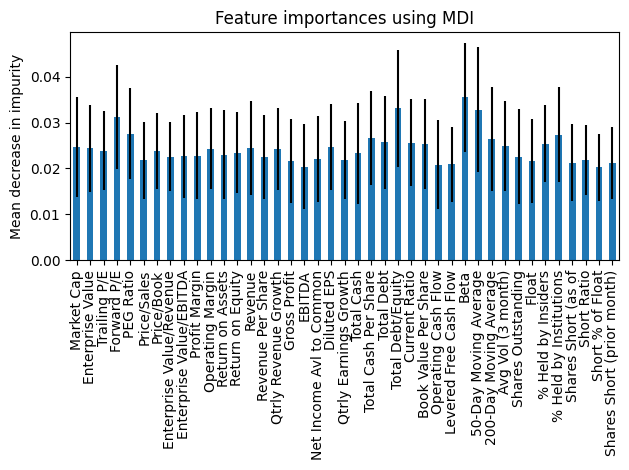

In [212]:
forest_importances = pd.Series(importances, index=features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

##KNN

In [213]:
knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=50)

In [214]:
# Feature List per Ticker
forward_sample = forward_sample.set_index('Date')
forward_sample.dropna(axis=0, how='any', inplace=True)
features = forward_sample.columns[6:]
X_test = forward_sample[features].values

#Lista tickerów
z = forward_sample['Ticker'].values

In [215]:
len(z)

286

In [216]:
y_pred = rfc.predict(X_test)

#y_pred.map(lambda x : True if 1 False if 0)
y_pred_b = y_pred.astype(bool)

if sum(y_pred) == 0:
      print("No stocks predicted!")
else:
  invest_list = z[y_pred_b].tolist()
  print(
        f"{len(invest_list)} stocks predicted to outperform the S&P500 by more than {OUTPERFORMANCE}%:"
        )
  print(" ".join(invest_list))


34 stocks predicted to outperform the S&P500 by more than 10%:
ABC LSI TRV IP PH OI BAX FDX INTU SWK WGO DGX LH SNA GT BIIB DHI BWA GES GNW DNR LLL LYB R PBI BLK DLX DIS GTN AMP LMT LM PHM APD


In [217]:
len(y_test)


286

In [218]:
len(y_pred)

286

In [219]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6258741258741258


In [220]:
y_pred2 = knn.predict(X_test)

#y_pred.map(lambda x : True if 1 False if 0)
y_pred2_b = y_pred.astype(bool)

if sum(y_pred2) == 0:
      print("No stocks predicted!")
else:
  invest_list = z[y_pred2_b].tolist()
  print(
        f"{len(invest_list)} stocks predicted to outperform the S&P500 by more than {OUTPERFORMANCE}%:"
        )
  print(" ".join(invest_list))

34 stocks predicted to outperform the S&P500 by more than 10%:
ABC LSI TRV IP PH OI BAX FDX INTU SWK WGO DGX LH SNA GT BIIB DHI BWA GES GNW DNR LLL LYB R PBI BLK DLX DIS GTN AMP LMT LM PHM APD


In [221]:
accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy:", accuracy)

Accuracy: 0.6153846153846154


# BackTesting - Lib

In [ ]:
import backtesting
from backtesting import Backtest, Strategy
from backtesting.lib import crossover


In [ ]:
stock_prices.set_index('Date', inplace=True)
stock_prices.index = pd.to_datetime(stock_prices.index)
stock_prices

In [ ]:
sp500_data = sp500_index
data_stocks = stock_prices[invest_list]
prediction = invest_list

In [ ]:
data_stocks.head()

In [ ]:
data_stocks = data_stocks.sum(axis=1)
data_stocks = pd.DataFrame({'Close': data_stocks})

In [ ]:
data_stocks.head()

In [ ]:
#data_stocks = data_stocks.stack().reset_index()
#data_stocks.columns = ['Date', 'Ticker', 'Close']

In [ ]:
data_stocks['Open'] = data_stocks['Close']
data_stocks['High'] = data_stocks['Close']
data_stocks['Low'] = data_stocks['Close']
data_stocks['Volume'] = 0

In [ ]:
data_stocks.head()

In [ ]:
data_stocks

In [ ]:
# Define your custom strategy
class MyStrategy(Strategy):
    def init(self):
        pass

    def next(self):
        if crossover(self.data.Close, self.data.Open):
            self.buy()


# Run the backtest
bt = Backtest(data_stocks, MyStrategy)

# View the performance metrics and equity curve
results = bt.run()
print(results)
bt.plot()

In [ ]:
sp_a = pd.read_csv('DataFrame_SP500_all.csv')

In [ ]:
sp_a.head()

In [ ]:
sp_a.date.min()

In [ ]:
sp_a.date.max()

In [ ]:
class BasketStrategy(Strategy):
    def init(self):
        # Store the selected tickers separately
        self.tickers = set(self.data['Ticker'])
    
    def next(self):
        for ticker in self.tickers:
            # Filter the data for the specific ticker
            ticker_data = self.data[self.data['Ticker'] == ticker]
            
            if len(ticker_data) >= 2:
                close_prices = ticker_data['Close']
                
                if close_prices[-2] < close_prices[-1]:
                    self.buy(ticker=ticker)
                elif close_prices[-2] > close_prices[-1]:
                    self.sell(ticker=ticker)




In [ ]:
bt = Backtest(data_stocks, BasketStrategy)
results = bt.run()

print(results)
bt.plot()


In [ ]:
class MyStrategy(Strategy):
    def __init__(self):
        self.stocks_to_buy = prediction
    
    def next(self):
        if self.data_stocks.index.year == 2005:
            for stock in self.stocks_to_buy:
                if stock in self.data_stocks.columns:  # Check if the stock is available in the data
                        self.buy(stock, 1)  # Buy one share of the stock
'''
    def next_open(self):
        # Kup pod koniec 2005 (następny rok to 2006 a następny miesiąc to styczeń)
        if self.data_stocks.index[-1].year == 2006 and self.data_stocks.index[-1].month == 1:
            for stock in self.stocks_to_buy:
                self.buy(stock, 1)  # Buy 1 share of each stock
'''

In [ ]:
bt = Backtest(data_stocks, MyStrategy)
results = bt.run()
print(results)

# BackTesting

In [ ]:
from sklearn.metrics import precision_score

In [ ]:
def status_calc(stock, sp500, outperformance=10):
    if outperformance < 0:
        raise ValueError("outperformance must be positive")
    return stock - sp500 >= outperformance

In [ ]:
def status_calc(stock, sp500, outperformance=10):
    if outperformance < 0:
        raise ValueError("outperformance must be positive")
    return stock - sp500 >= outperformance


def backtest():

    #Keystats zawiera wskaźniki finansowe spółek
    data_df = pd.read_csv("keystats.csv", index_col="Date")
    data_df.dropna(axis=0, how="any", inplace=True)

    #Pierwsze 6 kolumn jest zbędne
    features = data_df.columns[6:]
    X = data_df[features].values

    # Funkcja status_calc sprawdza, czy dany ticker outperformuje sp500
    y = list(
        status_calc(
            data_df["stock_p_change"], data_df["SP500_p_change"], outperformance=10
        )
    )

    # Tracking returnów
    z = np.array(data_df[["stock_p_change", "SP500_p_change"]])

    #Train test split
    X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(
        X, y, z, test_size=0.2
    )

    # Instantiate a RandomForestClassifier with 100 trees, then fit it
    clf = RandomForestClassifier(n_estimators=100, random_state=0)
    clf.fit(X_train, y_train)

    # Generate the predictions, then print test set accuracy and precision
    y_pred = clf.predict(X_test)
    print("Classifier performance\n", "=" * 20)
    print(f"Accuracy score: {clf.score(X_test, y_test): .2f}")
    print(f"Precision score: {precision_score(y_test, y_pred): .2f}")

   
    num_positive_predictions = sum(y_pred)
    if num_positive_predictions < 0:
        print("No stocks predicted!")
    stock_returns = 1 + z_test[y_pred, 0] / 100
    market_returns = 1 + z_test[y_pred, 1] / 100

    avg_predicted_stock_growth = sum(stock_returns) / num_positive_predictions
    index_growth = sum(market_returns) / num_positive_predictions
    percentage_stock_returns = 100 * (avg_predicted_stock_growth - 1)
    percentage_market_returns = 100 * (index_growth - 1)
    total_outperformance = percentage_stock_returns - percentage_market_returns

    print("\n Stock prediction performance report \n", "=" * 40)
    print(f"Total Trades:", num_positive_predictions)
    print(f"Average return for stock predictions: {percentage_stock_returns: .1f} %")
    print(
        f"Average market return in the same period: {percentage_market_returns: .1f}% "
    )
    print(
        f"Compared to the index, our strategy earns {total_outperformance: .1f} percentage points more"
    )


if __name__ == "__main__":
    backtest()

In [ ]:
def backtest():

    data_df = pd.read_csv("keystats.csv", index_col="Date")
    data_df.dropna(axis=0, how="any", inplace=True)

    features = data_df.columns[6:]
    X = data_df[features].values

    y = list(
        status_calc(
            data_df["stock_p_change"], data_df["SP500_p_change"], outperformance=10
        )
    )

    # z is required for us to track returns
    z = np.array(data_df[["stock_p_change", "SP500_p_change"]])

    # Generate the train set and test set by randomly splitting the dataset
    X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(
        X, y, z, test_size=0.2
    )

    # Instantiate a RandomForestClassifier with 100 trees, then fit it to the training data
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X_train, y_train)

    # Generate the predictions, then print test set accuracy and precision
    y_pred = clf.predict(X_test)
    print("Classifier performance\n", "=" * 20)
    print(f"Accuracy score: {clf.score(X_test, y_test): .2f}")
    print(f"Precision score: {precision_score(y_test, y_pred): .2f}")

   
    num_positive_predictions = sum(y_pred)
    if num_positive_predictions < 0:
        print("No stocks predicted!")
    stock_returns = 1 + z_test[y_pred, 0] / 100
    market_returns = 1 + z_test[y_pred, 1] / 100

    avg_predicted_stock_growth = sum(stock_returns) / num_positive_predictions
    index_growth = sum(market_returns) / num_positive_predictions
    percentage_stock_returns = 100 * (avg_predicted_stock_growth - 1)
    percentage_market_returns = 100 * (index_growth - 1)
    total_outperformance = percentage_stock_returns - percentage_market_returns

    print("\n Stock prediction performance report \n", "=" * 40)
    print(f"Total Trades:", num_positive_predictions)
    print(f"Average return for stock predictions: {percentage_stock_returns: .1f} %")
    print(
        f"Average market return in the same period: {percentage_market_returns: .1f}% "
    )
    print(
        f"Compared to the index, our strategy earns {total_outperformance: .1f} percentage points more"
    )


if __name__ == "__main__":
    backtest()

##Backtesting2

Aby dokonać backtestingu należy 
- Stworzyć indeks z akcji wybranych spółek (Suma Closing Price do jednej kolumny)
- Porównać indeks z indeksem SP500   

In [222]:
data = yf.download('''^GSPC ABC LSI TRV IP PH OI BAX FDX
 INTU SWK WGO DGX LH SNA GT BIIB DHI BWA GES GNW DNR LLL
 LYB R PBI BLK DLX DIS GTN AMP LMT LM PHM APD AAPL''', start="2002-01-01", end="2022-01-01")

[*********************100%***********************]  36 of 36 completed

3 Failed downloads:
- DNR: No timezone found, symbol may be delisted
- LM: No timezone found, symbol may be delisted
- LLL: No timezone found, symbol may be delisted


In [223]:
closing_prices = data['Adj Close']

In [224]:
GSPC = closing_prices['^GSPC']
index = closing_prices.drop(columns=['^GSPC'], axis=1)
selected_stock_prices = index.copy()
index = index.sum(axis=1)
index = pd.DataFrame(index, columns=['index'])

In [225]:
porownanie = pd.concat([GSPC, index], axis=1)

In [233]:
porownanie.index = pd.to_datetime(porownanie.index, errors='coerce')

In [236]:
mask = (porownanie.index > '2014-01-01')
porownanie = porownanie.loc[mask]

In [240]:
porownanie.head()

,^GSPC,index,procent
Date,,,
2014-01-02,1831.979980,2088.001361,0.139751
2014-01-03,1831.369995,2087.472458,0.139842
2014-01-06,1826.770020,2076.474528,0.136692
2014-01-07,1837.880005,2090.383667,0.137389
2014-01-08,1837.489990,2106.846548,0.146589


<Axes: xlabel='Date'>

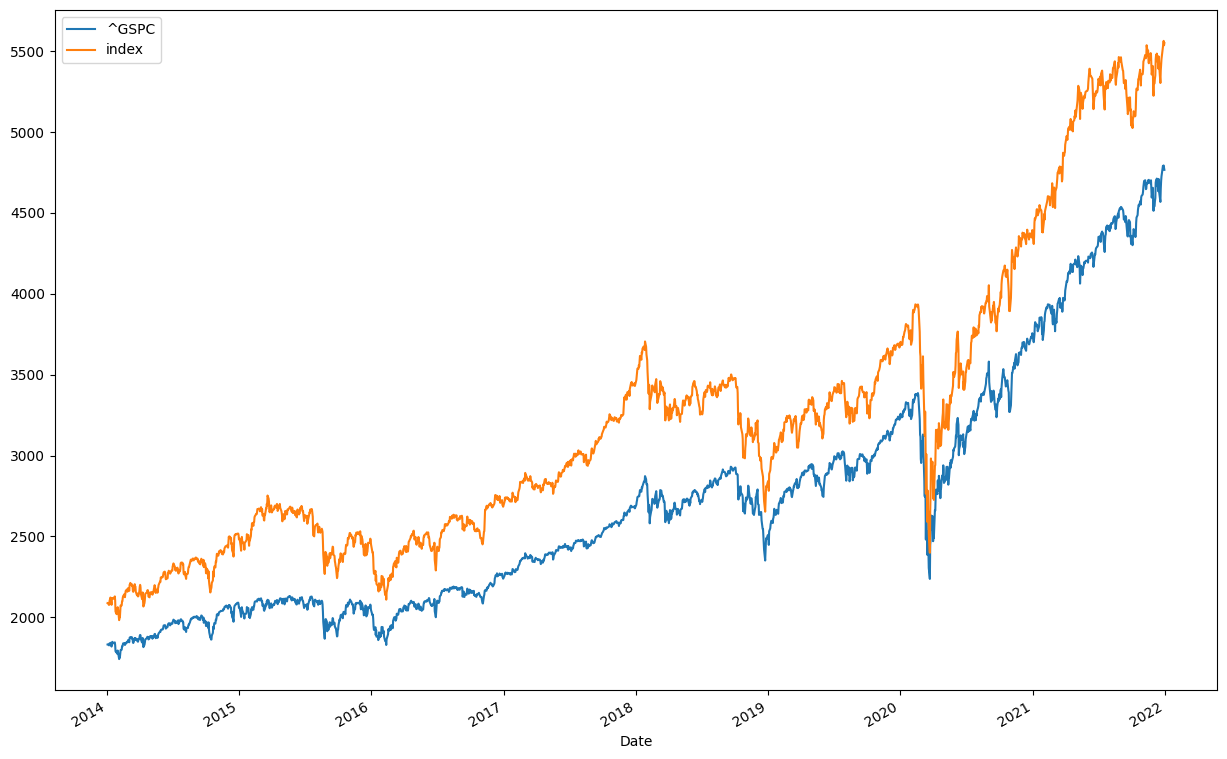

In [237]:
porownanie.plot(figsize=(15,10))

In [239]:
porownanie['procent'] = (porownanie['index'] / porownanie['^GSPC'])-1

<ipython-input-239-cb22cd09583c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  porownanie['procent'] = (porownanie['index'] / porownanie['^GSPC'])-1


In [242]:
porownanie['procent'].mean()

0.18808019856254377

In [246]:
print(porownanie['index'].corr(porownanie['^GSPC']))

0.991551198617686


In [251]:
porownanie['^GSPC'].std()/porownanie['^GSPC'].mean()

0.27577433592246414

In [252]:
porownanie['index'].std()/porownanie['index'].mean()

0.2758194244267652

In [255]:
last_row = porownanie.iloc[-1]
first_row = porownanie.iloc[0]
result = (last_row - first_row)/first_row

# Print the result
print(result)

^GSPC      1.601655
index      1.657980
procent    0.176566
dtype: float64


#Symulacja


Dataframe przechowujący dane


In [ ]:
selected_stock_prices

,AAPL,ABC,AMP,APD,BAX,BIIB,BLK,BWA,DGX,DHI,...,LYB,OI,PBI,PH,PHM,R,SNA,SWK,TRV,WGO
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-02,0.353636,12.041754,NaN,26.365667,19.596361,68.150002,26.198349,5.224732,26.134199,8.138099,...,NaN,9.781261,13.687709,21.450998,9.259278,13.015620,19.726994,27.163635,25.374262,15.216768
2002-01-03,0.357886,11.821414,NaN,26.360048,19.397079,63.939999,26.261744,5.236702,25.472000,8.052980,...,NaN,9.791062,14.191737,21.803185,9.255093,12.974566,19.426580,26.578514,25.217201,15.319037
2002-01-04,0.359556,11.524446,NaN,26.651764,19.504091,64.769997,26.578758,5.287574,25.716572,8.037966,...,NaN,9.781261,14.030874,22.058056,9.257180,13.344085,19.497261,26.418926,25.298651,14.836351
2002-01-07,0.347566,11.122089,NaN,26.814455,19.360172,62.310001,26.249077,5.190820,25.472000,7.962865,...,NaN,10.173297,14.080924,22.076593,9.236255,13.514192,19.438354,26.082060,24.926344,15.241308
2002-01-08,0.343164,11.192985,NaN,26.449797,19.183025,64.260002,26.280773,5.277598,25.528440,7.965369,...,NaN,10.486924,14.209615,21.617815,8.987192,13.690158,19.350004,25.650595,24.676218,14.848629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,178.768845,129.493195,299.733490,291.370544,83.904579,234.190002,884.068115,43.293430,164.516541,104.461601,...,81.168442,11.910000,6.152221,308.465363,54.454849,76.929222,205.744690,174.990814,151.105957,70.225784
2021-12-28,177.737839,129.944794,298.056335,293.076965,84.049911,235.990005,883.349365,43.849976,164.506821,105.189415,...,82.098152,11.800000,6.142970,309.332672,55.339817,77.341064,208.562057,177.281555,152.151810,73.304565
2021-12-29,177.827057,130.906937,297.802734,294.436371,84.476219,258.309998,871.754333,43.810921,165.254868,106.576202,...,82.053871,11.970000,6.031952,310.482635,56.686932,78.126450,209.033218,177.946945,152.519806,73.842133


###Zakup w 2014

Dokonujemy zakupu za 100tys przeznaczone po równo na wszystkie spółki


In [ ]:
single_ticker_budget = 100000/len(invest_list)
single_ticker_budget

2941.176470588235

In [ ]:
buy_price_data = selected_stock_prices.loc[datetime.date(year=2014,month=1,day=1):datetime.date(year=2014,month=1,day=2)]
price_change_data = selected_stock_prices.loc[datetime.date(year=2014,month=1,day=1):]
buy_price_data
price_change_data

<ipython-input-79-a48b12744849>:1: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  buy_price_data = selected_stock_prices.loc[datetime.date(year=2014,month=1,day=1):datetime.date(year=2014,month=1,day=2)]
<ipython-input-79-a48b12744849>:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  price_change_data = selected_stock_prices.loc[datetime.date(year=2014,month=1,day=1):]


,AAPL,ABC,AMP,APD,BAX,BIIB,BLK,BWA,DGX,DHI,...,LYB,OI,PBI,PH,PHM,R,SNA,SWK,TRV,WGO
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,17.364962,60.331596,91.533173,82.676247,32.359970,280.329987,246.053543,47.823444,43.560421,19.642532,...,50.547222,34.822468,14.991076,107.141068,17.648458,54.603725,88.743080,65.402008,71.762207,23.951605
2014-01-03,16.983521,60.374794,91.549255,82.513031,32.411423,277.399994,247.131271,47.779915,43.701351,19.570545,...,50.502312,34.165817,15.259804,107.149498,17.613302,54.716457,88.914742,65.565170,71.625633,23.818495
2014-01-06,17.076138,60.158951,91.308151,82.713341,32.467537,274.970001,247.052582,47.875660,43.262009,19.138649,...,50.027500,34.508842,15.119043,105.970665,17.437521,53.821953,87.990959,64.961548,71.432861,23.570005
2014-01-07,16.954012,60.815037,92.087784,81.689545,32.640591,273.519989,249.325836,49.076908,44.323044,19.201630,...,50.649902,34.675457,15.144637,107.469460,17.173853,54.370689,88.195297,65.238876,71.015129,22.868948
2014-01-08,17.061382,61.410664,93.076416,81.674706,32.748169,290.010010,249.247238,48.989868,44.090927,19.417580,...,51.156765,34.616650,15.157433,107.511589,17.384789,54.558632,88.097221,65.320435,70.356384,22.877823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,178.768845,129.493195,299.733490,291.370544,83.904579,234.190002,884.068115,43.293430,164.516541,104.461601,...,81.168442,11.910000,6.152221,308.465363,54.454849,76.929222,205.744690,174.990814,151.105957,70.225784
2021-12-28,177.737839,129.944794,298.056335,293.076965,84.049911,235.990005,883.349365,43.849976,164.506821,105.189415,...,82.098152,11.800000,6.142970,309.332672,55.339817,77.341064,208.562057,177.281555,152.151810,73.304565
2021-12-29,177.827057,130.906937,297.802734,294.436371,84.476219,258.309998,871.754333,43.810921,165.254868,106.576202,...,82.053871,11.970000,6.031952,310.482635,56.686932,78.126450,209.033218,177.946945,152.519806,73.842133


In [ ]:
buy_price_data

,AAPL,ABC,AMP,APD,BAX,BIIB,BLK,BWA,DGX,DHI,...,LYB,OI,PBI,PH,PHM,R,SNA,SWK,TRV,WGO
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02 00:00:00,17.364962,60.331596,91.533173,82.676247,32.35997,280.329987,246.053543,47.823444,43.560421,19.642532,...,50.547222,34.822468,14.991076,107.141068,17.648458,54.603725,88.74308,65.402008,71.762207,23.951605


In [ ]:
buy_price_data= buy_price_data.reset_index()
buy_price_data = buy_price_data.drop(columns ="Date")
buy_price_data

,AAPL,ABC,AMP,APD,BAX,BIIB,BLK,BWA,DGX,DHI,...,LYB,OI,PBI,PH,PHM,R,SNA,SWK,TRV,WGO
0,17.364962,60.331596,91.533173,82.676247,32.35997,280.329987,246.053543,47.823444,43.560421,19.642532,...,50.547222,34.822468,14.991076,107.141068,17.648458,54.603725,88.74308,65.402008,71.762207,23.951605


In [ ]:
# Calculate the amounts of stocks that can be bought with $2000
amounts_df = single_ticker_budget / buy_price_data

# Print the amounts DataFrame
amounts_df = amounts_df.transpose().reset_index()
amounts_df.columns = ["Ticker","Quantity"]
amounts_df

,Ticker,Quantity
0,AAPL,169.374199
1,ABC,48.750185
2,AMP,32.132356
3,APD,35.574625
4,BAX,90.889345
5,BIIB,10.491837
6,BLK,11.953400
7,BWA,61.500724
8,DGX,67.519468
9,DHI,149.735096


In [ ]:
value_change_frame = price_change_data.copy()

In [ ]:
for i, row in amounts_df.iterrows():
  value_change_frame[row["Ticker"]] = price_change_data[row["Ticker"]]*row["Quantity"]

In [ ]:
value_change_frame

,AAPL,ABC,AMP,APD,BAX,BIIB,BLK,BWA,DGX,DHI,...,LYB,OI,PBI,PH,PHM,R,SNA,SWK,TRV,WGO
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,2941.176471,2941.176471,2941.176471,2941.176471,2941.176471,2941.176471,2941.176471,2941.176471,2941.176471,2941.176471,...,2941.176471,2941.176471,2941.176471,2941.176471,2941.176471,2941.176471,2941.176471,2941.176471,2941.176471,2941.176471
2014-01-03,2876.570187,2943.282363,2941.693248,2935.370136,2945.852967,2910.435466,2954.058988,2938.499374,2950.692001,2930.397467,...,2938.563280,2885.714430,2993.899464,2941.407899,2935.317560,2947.248666,2946.865775,2948.513996,2935.578989,2924.831005
2014-01-06,2892.257123,2932.759967,2933.946004,2942.496080,2950.953150,2884.940379,2953.118380,2944.387766,2921.027829,2865.727447,...,2910.935559,2914.687037,2966.282952,2909.047237,2906.023009,2899.067050,2916.249226,2921.368651,2927.678226,2894.317345
2014-01-07,2871.572193,2964.744279,2958.997435,2906.074918,2966.681891,2869.727088,2980.291499,3018.265399,2992.668359,2875.157861,...,2947.151094,2928.759639,2971.304323,2950.191304,2862.081817,2928.624211,2923.021521,2933.840317,2910.557456,2808.229852
2014-01-08,2889.757965,2993.781197,2990.764517,2905.547020,2976.459610,3042.737694,2979.351986,3012.912379,2976.995963,2907.493157,...,2976.643762,2923.792649,2973.814728,2951.347820,2897.234961,2938.747551,2919.771031,2937.508051,2883.558778,2809.319659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,30278.829911,6312.817162,9631.143148,10365.397854,7626.032203,2457.083287,10567.619983,2662.577326,11108.069367,15641.567912,...,4722.924446,1005.942816,1207.035951,8467.818059,9075.088426,4143.717597,6818.914106,7869.465795,6193.082735,8623.489982
2021-12-28,30104.204119,6334.832703,9577.252222,10426.103137,7639.241364,2475.968625,10559.028477,2696.805262,11107.413088,15750.547170,...,4777.021233,996.652021,1205.220927,8491.626955,9222.571363,4165.901084,6912.288994,7972.482103,6235.947041,9001.553943
2021-12-29,30119.315370,6381.737349,9569.103422,10474.463479,7677.988189,2710.146339,10420.428422,2694.403359,11157.920816,15958.197917,...,4774.444667,1011.010573,1183.439792,8523.195105,9447.072651,4208.205089,6927.904491,8002.405182,6251.029379,9067.565379


In [ ]:

type(value_change_frame.columns)
col_list = list(value_change_frame.columns)
col_list

['AAPL',
 'ABC',
 'AMP',
 'APD',
 'BAX',
 'BIIB',
 'BLK',
 'BWA',
 'DGX',
 'DHI',
 'DIS',
 'DLX',
 'DNR',
 'FDX',
 'GES',
 'GNW',
 'GT',
 'GTN',
 'INTU',
 'IP',
 'LH',
 'LLL',
 'LM',
 'LMT',
 'LSI',
 'LYB',
 'OI',
 'PBI',
 'PH',
 'PHM',
 'R',
 'SNA',
 'SWK',
 'TRV',
 'WGO']

Top 3 i bottom 3 kolorem, reszta na szaro

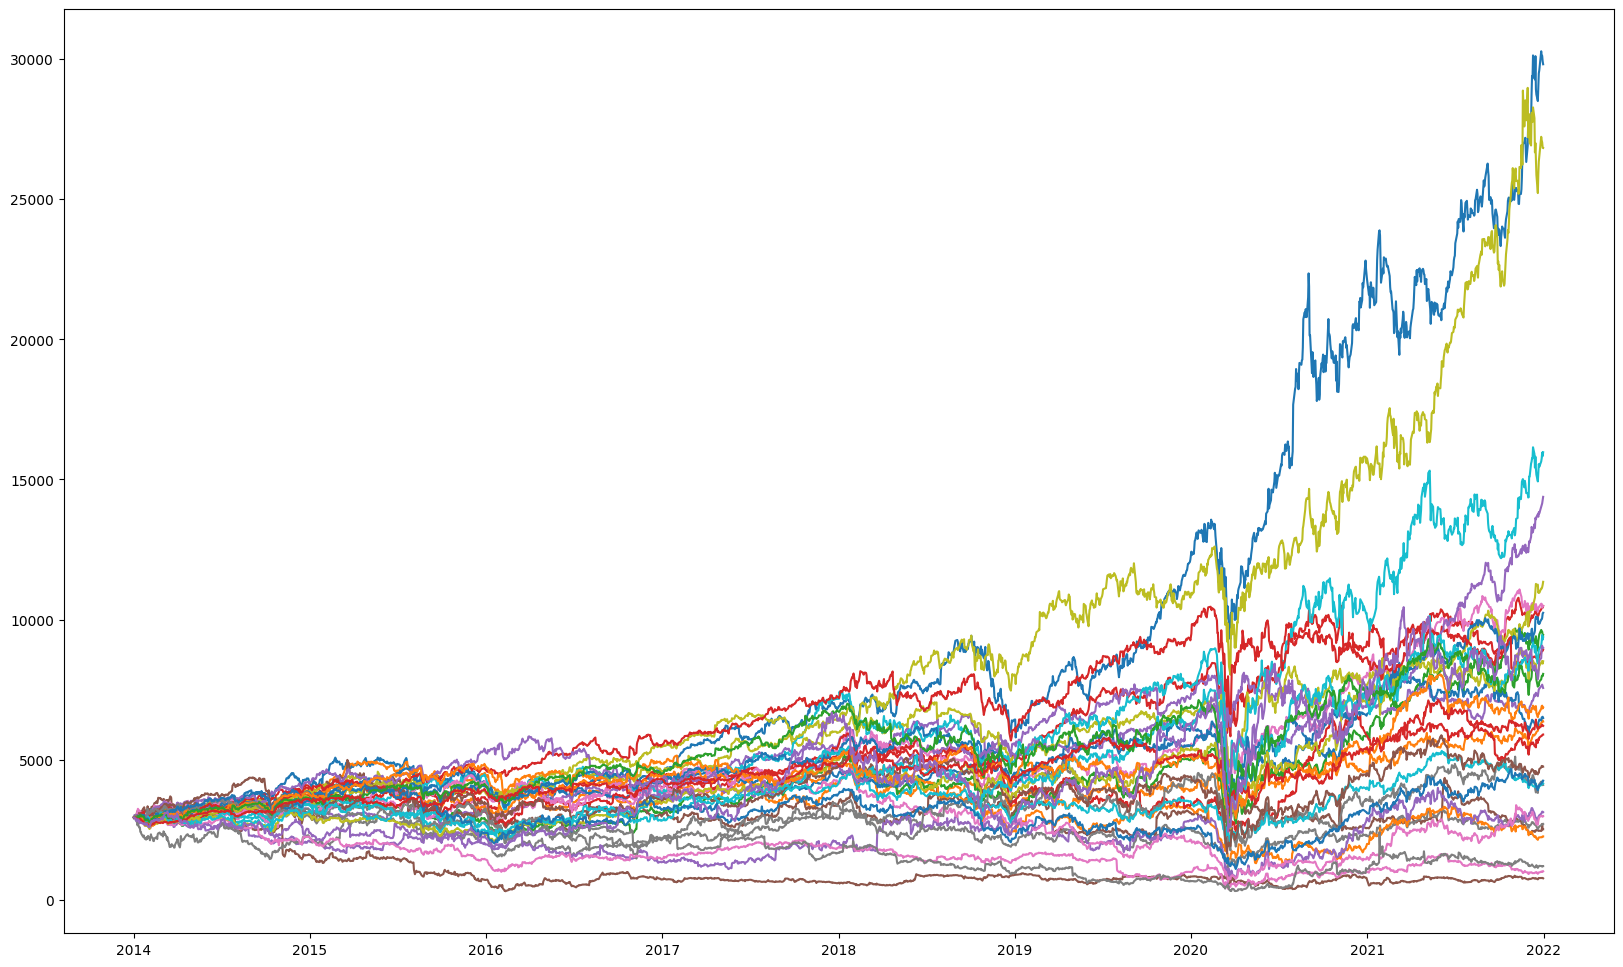

In [ ]:
plt.figure(figsize = (20,12))

plt.plot(value_change_frame[col_list])